This is the beginning of the data cleaning and some very short exploratory analysis. 

In the end of the notebook is a dataframe that is similar to what we will have as an imput for the decision tree. 
So far only for the pickup of the bikes, but we will do the same for the return of the bikes. 

It is really just a rough start of the data preprocessing, only to make you more familiar with the data. 

In [1]:
import pandas as pd
import os 
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import math
import numpy as np
cwd = os.getcwd()

In [2]:
from os import listdir
from os.path import isfile, join

path = cwd+'/data/2018'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

In [3]:
files

['201801_capitalbikeshare_tripdata.csv',
 '201802-capitalbikeshare-tripdata.csv',
 '201803-capitalbikeshare-tripdata.csv',
 '201804-capitalbikeshare-tripdata.csv',
 '201805-capitalbikeshare-tripdata.csv']

In [4]:
data = pd.read_csv(path+'/'+files[0])
for file in files[1:]:
    data_month = pd.read_csv(path+'/'+file)
    print(data.shape, data_month.shape)
    data = data.append(data_month, ignore_index = True)

(168590, 9) (182378, 9)
(350968, 9) (238998, 9)
(589966, 9) (328907, 9)
(918873, 9) (374115, 9)


In [5]:
data.columns

Index(['Duration', 'Start date', 'End date', 'Start station number',
       'Start station', 'End station number', 'End station', 'Bike number',
       'Member type'],
      dtype='object')

# date time

First some data cleaning and feature ingeneering on the timestamp.

For exploratory analysis it makes sense to look at the start time in time-intervals instead of continuous time. (clean_time, here 15-min-intervals)

Also we're interested in the date (for weekday/weekend, holiday, season). 

In [6]:
def create_datetime(time_str):
    return datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')

In [7]:
def clean_time(time_datetime, interval_size):
    """
    Devide time into intervals of interval_size
    """
    new_minute = math.floor(time_datetime.minute/interval_size)*interval_size
    return time_datetime.replace(minute=new_minute, 
                                second=0, 
                                microsecond=0).time()

In [8]:
data['starttime'] = data['Start date'].apply(lambda x: create_datetime(x))

In [9]:
data['time'] = data['starttime'].apply(lambda x: clean_time(x, 15))
data['date'] =  data['starttime'].apply(lambda x: x.date())
data['hour'] =  data['starttime'].apply(lambda x: x.hour)
data['weekday'] = data['starttime'].apply(lambda x: x.weekday())

In [10]:
monday = data[data.weekday == 0].time.value_counts().sort_index()
tuesday = data[data.weekday == 1].time.value_counts().sort_index()
wednesday = data[data.weekday == 2].time.value_counts().sort_index()
thursday = data[data.weekday == 3].time.value_counts().sort_index()
friday = data[data.weekday == 4].time.value_counts().sort_index()
saturday = data[data.weekday == 5].time.value_counts().sort_index()
sunday = data[data.weekday == 6].time.value_counts().sort_index()

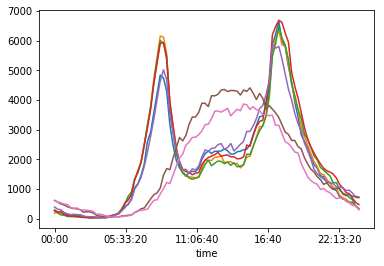

In [11]:
plt.plot(monday)
plt.plot(tuesday)
plt.plot(wednesday)
plt.plot(thursday)
plt.plot(friday)
plt.plot(saturday)
plt.plot(sunday)

# geo data

In [12]:
stations = pd.read_csv(cwd+'/data/Capital_Bike_Share_Locations.csv')

In [13]:
stations.head()

,OBJECTID,ID,ADDRESS,TERMINAL_NUMBER,LATITUDE,LONGITUDE,INSTALLED,LOCKED,INSTALL_DATE,REMOVAL_DATE,TEMPORARY_INSTALL,NUMBER_OF_BIKES,NUMBER_OF_EMPTY_DOCKS,X,Y,SE_ANNO_CAD_DATA,OWNER
0,264410090,556,18th & New Hampshire Ave NW,31324,38.911268,-77.041829,YES,NO,NaN,NaN,NO,9,10,396372.164153,138156.972226,NaN,DC
1,264410091,560,Dunn Loring Metro,32231,38.882800,-77.228300,YES,NO,NaN,NaN,NO,8,8,380191.621348,135020.735550,NaN,NaN
2,264410092,561,Oglethorpe St & 42nd Ave,32408,38.959361,-76.946361,YES,NO,NaN,NaN,NO,5,3,404648.982007,143496.250343,NaN,NaN
3,264410093,562,Southern Ave Metro,32409,38.840107,-76.975300,YES,NO,NaN,NaN,NO,6,9,402144.372341,130257.022934,NaN,NaN
4,264410094,563,Queens Chapel & Hamilton St,32410,38.954600,-76.959500,YES,NO,NaN,NaN,NO,2,13,403510.437423,142967.148407,NaN,NaN


In [14]:
stations['CAPACITY'] = stations.NUMBER_OF_BIKES+stations.NUMBER_OF_EMPTY_DOCKS
stations = stations[['TERMINAL_NUMBER', 'LATITUDE', 'LONGITUDE', 'CAPACITY']]
stations.columns = ['id', 'latitude', 'longitude', 'capacity']

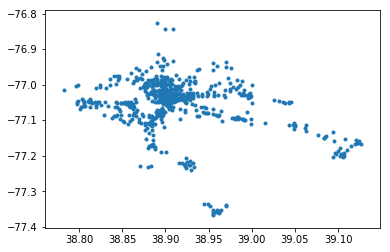

In [15]:
plt.scatter(stations.latitude, stations.longitude, marker='.')

Because the rented bikes per hour were pretty small at one station, I had the idea of combining stations that are close to each other. Because as a user you are usually not fixed on a specific station, you would look on the map in the application and then go to any close station that has bikes. 

In the next step I manually combined the stations that are close to each other imagine a grid that lays over the map and all the stations in one cell are combined to one. 
If we bundle stations, we should think about a smarter way.

In [16]:
grid_size = 25
offset_lat = (stations.latitude.max() - stations.latitude.min())/grid_size
offset_lon = (stations.longitude.max() - stations.longitude.min())/grid_size
stations['lat'] = stations.latitude.apply(lambda x: math.floor(x/offset_lat)*offset_lat)
stations['lon'] = stations.longitude.apply(lambda x: math.floor(x/offset_lon)*offset_lon)

In [17]:
new_stat = stations.groupby(['lat', 'lon']).count().reset_index()
new_stat.id = range(0,new_stat.shape[0])
new_stat = new_stat[['id', 'lat', 'lon']]

In [18]:
stations_rough = stations.merge(new_stat, how='left', 
               left_on=['lat', 'lon'], 
              right_on=['lat', 'lon'])

In [19]:
stations_rough.head(10) 
#id_y is the new station id, see how id 101 appears twice...

,id_x,latitude,longitude,capacity,lat,lon,id_y
0,31324,38.911268,-77.041829,19,38.910348,-77.045672,71
1,32231,38.882800,-77.228300,16,38.869144,-77.241109,30
2,32408,38.959361,-76.946361,8,38.951552,-76.958811,96
3,32409,38.840107,-76.975300,15,38.827940,-76.980526,16
4,32410,38.954600,-76.959500,15,38.951552,-76.980526,95
5,32411,38.975505,-76.952199,15,38.965287,-76.958811,102
6,32412,38.974205,-76.995227,14,38.965287,-77.002241,101
7,32413,38.939271,-76.955047,15,38.937818,-76.958811,88
8,32414,38.972500,-76.980700,15,38.965287,-77.002241,101
9,32415,38.796800,-77.002600,14,38.786736,-77.023956,3


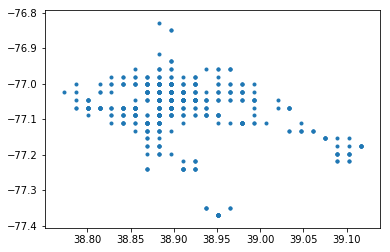

In [20]:
plt.scatter(stations_rough.lat, stations_rough.lon, marker='.')

# station pickup count

In [21]:
data = data[['starttime', 'weekday', 'Start station number', 'time', 'date']]

In [22]:
# within next 90 minutes will have x pickups at station
time = datetime(year=2018, month=4, day=2, hour=6, minute=0)
delta = timedelta(minutes=90)
    
for i in range(0,8):  # loop is irrelevant right now, further down we only look at the last time-interval
    print(time, time+delta)
    pickups = data[(data.starttime >= time) & (data.starttime < time+delta)].groupby(['Start station number']).count()
    time += delta

2018-04-02 06:00:00 2018-04-02 07:30:00
2018-04-02 07:30:00 2018-04-02 09:00:00
2018-04-02 09:00:00 2018-04-02 10:30:00
2018-04-02 10:30:00 2018-04-02 12:00:00
2018-04-02 12:00:00 2018-04-02 13:30:00
2018-04-02 13:30:00 2018-04-02 15:00:00
2018-04-02 15:00:00 2018-04-02 16:30:00
2018-04-02 16:30:00 2018-04-02 18:00:00


In [23]:
# pickups between 16:30-18:00 per station (uncombined stations)
pickups = pickups.reset_index()
pickups.head()

,Start station number,starttime,weekday,time,date
0,31002,1,1,1,1
1,31003,2,2,2,2
2,31005,5,5,5,5
3,31006,2,2,2,2
4,31007,4,4,4,4


In [24]:
# merge uncombined stations with grid-stations (new station id, id_y)
window = stations_rough.merge(pickups, how='right', left_on='id_x', right_on='Start station number')

In [25]:
window = window.groupby(['id_y', 'lat', 'lon']).sum().reset_index()[['id_y', 'lat', 'lon', 'time']]
window.columns = ['station_id', 'lat', 'lon', 'pickups']
window['timeframe']  = time.time()
window.head(10)

,station_id,lat,lon,pickups,timeframe
0,6.0,38.800471,-77.067387,13,18:00:00
1,7.0,38.800471,-77.045672,5,18:00:00
2,8.0,38.814206,-77.067387,10,18:00:00
3,11.0,38.827940,-77.110817,1,18:00:00
4,12.0,38.827940,-77.089102,1,18:00:00
5,18.0,38.841675,-77.089102,2,18:00:00
6,19.0,38.841675,-77.067387,10,18:00:00
7,20.0,38.841675,-77.002241,1,18:00:00
8,25.0,38.855410,-77.067387,15,18:00:00
9,27.0,38.855410,-77.002241,3,18:00:00


This dataframe above is the most minimal version of what we will have as the input of the decision trees. 

- station_id: identifier (here I used the grid-ids, the "combined stations")
- lat/lon: location of the station, here one-to-one mapping

other variables that will be usefull for the decision tree:
- timeframe: We should think about how to represent the timeframe better, here I just used the end-time. 
- weekday/weekend: either 0-1 (two categories) or 0-6 (each day)
- holiday: 0-1
- season: 0-3 (4 seasons), or 0-11 (12 months)?
- weather: sunny, rainy, windy, snowy, cold ... I really think we should put in some effort to get data. It should not take too long once we've found a nice dataset
- inner-/outer city: maybe we don't need it because it is already somehow captured in the location (lat/lon). Will have high correlation with this one
- how many other stations in cluster: No idea if it's important, but I guess it has some relevance.
- ... please complete
- type of customer (membership or occasional)

target variable:
- pickups: how many bikes got picked up at the station. Integers or integer-ranges?

In [26]:
# logarithmic value to see the distribution better in the color scheme
window['log_pickups'] = np.log(window.pickups) 

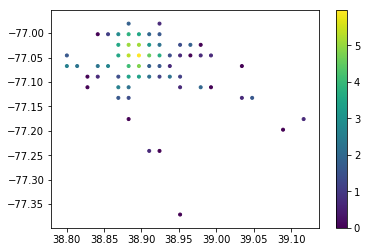

In [27]:
plt.scatter(window.lat, window.lon, marker='.', c=window.log_pickups, cmap='viridis')
plt.colorbar()

# What is next:

### Data:
- Data collection (trip data, stations, weather, holiday (bank-)...)
- more data cleaning and feature engineering, find more features
- split data for cross validation (leave out part for prediction of the trees and for training of the NNet/combination of trees)

### AI-Part:
#### Build trees
- code for decision tree with Entropy/Information Gain
- code for decision tree with random split
- random forest trees (where one variable is left out)
- other ways of building trees

#### Combine trees:
- uniformly
- with fancy Neural Nets
- something like AdaBoost

### Visualization
- demand on map
- time moving map?
- real-time prediction?

